<a href="https://colab.research.google.com/github/advaitkumar3107/MoNuSeg/blob/master/unet_naive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import sys
import random
import warnings
from hyperopt import hp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing 
IMG_HEIGHT = 128 # for faster computing
IMG_CHANNELS = 3
TRAIN_PATH = 'Datasets/nucleus/'
TEST_PATH = 'Datasets/test/'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [0]:
os.chdir('/content/drive/My Drive/amit sethi/')
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [0]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
    
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img


Getting and resizing train images and masks ... 


100%|██████████| 24/24 [00:37<00:00,  1.48s/it]

Getting and resizing test images ... 



100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


In [0]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=180, zoom_range=0.5, width_shift_range=0.5, height_shift_range=0.5, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=180, zoom_range=0.5, width_shift_range=0.5, height_shift_range=0.5, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

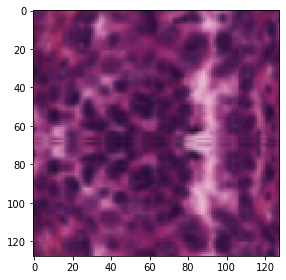

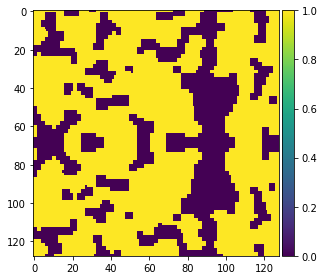

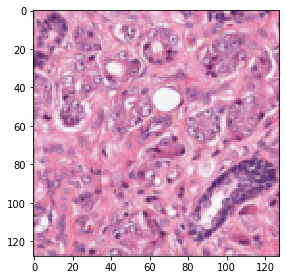

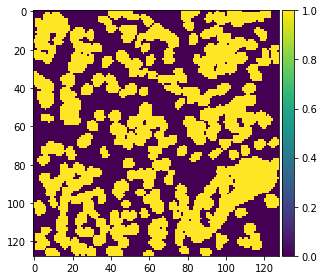

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [0]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [0]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
#hyperparameter optimization using hyperopt SMBO
from hyperopt import hp, fmin, tpe, Trials

space = {
    'dropout_c3' : hp.loguniform('dropout_c3', 0, 1),
    'dropout_c4' : hp.loguniform('dropout_c4', 0, 1),
    'dropout_c5' : hp.loguniform('dropout_c5', 0, 1),
    'dropout_c6' : hp.loguniform('dropout_c6', 0, 1),
    'dropout_c7' : hp.loguniform('dropout_c7', 0, 1),
    'epochs' : hp.randint('epochs', 10),
    'steps_per_epoch' : hp.randint('steps_per_epoch', 200)
}

In [0]:
                                                  def unet(space): 
                                                    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
                                                    s = Lambda(lambda x: x / 255) (inputs)
                                                    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
                                                    c1 = Dropout(0.1) (c1)
                                                    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
                                                    p1 = MaxPooling2D((2, 2)) (c1)
                                                    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
                                                    c2 = Dropout(0.2) (c2)
                                                    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
                                                    p2 = MaxPooling2D((2, 2)) (c2)
                                                    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
                                                    c3 = Dropout(space['dropout_c3']) (c3)
                                                    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
                                                    p3 = MaxPooling2D((2, 2)) (c3)
                                                    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
                                                    c4 = Dropout(space['dropout_c4']) (c4)
                                                    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)         
                                                    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
                                                    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
                                                    c5 = Dropout(space['dropout_c5']) (c5)
                                                    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)                                                                                                          
                                                    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
                                                    u6 = concatenate([u6, c4])
                                                    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
                                                    c6 = Dropout(space['dropout_c6']) (c6)                                                                                                            
                                                    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
                                                    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
                                                    u7 = concatenate([u7, c3])
                                                    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)                                                                                                            
                                                    c7 = Dropout(space['dropout_c7']) (c7)
                                                    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
                                                    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
                                                    u8 = concatenate([u8, c2])                                                                                                            
                                                    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
                                                    c8 = Dropout(0.2) (c8)
                                                    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
                                                    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)                                                                                                            
                                                    u9 = concatenate([u9, c1], axis=3)
                                                    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
                                                    c9 = Dropout(0.1) (c9)
                                                    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)                                                                                                            
                                                    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
                                                    model = Model(inputs=[inputs], outputs=[outputs])
                                                    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])                                                                                                        
                                                    results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=20, steps_per_epoch=1+space['steps_per_epoch'], epochs=1+space['epochs'])
                                                    accuracy = results.history['val_mean_iou']
                                                    return -accuracy[-1]


In [0]:
trials = Trials()
best = fmin(fn = unet, space = space, algo = tpe.suggest, trials = trials, max_evals = 15)
print("Found minimum after 15 trials:")
print(best)
print("")

  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.








Epoch 1/9
 1/74 [..............................]
 - ETA: 10:43 - loss: 0.7454 - mean_iou: 0.0000e+00

 2/74 [..............................]
 - ETA: 5:28 - loss: 0.7908 - mean_iou: 0.1529     

 3/74 [>.....................

In [0]:
                                                      inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
                                                      s = Lambda(lambda x: x / 255) (inputs)
                                                      c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
                                                      c1 = Dropout(0.1) (c1)
                                                      c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
                                                      p1 = MaxPooling2D((2, 2)) (c1)
                                                      c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
                                                      c2 = Dropout(0.2) (c2)
                                                      c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
                                                      p2 = MaxPooling2D((2, 2)) (c2)
                                                      c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
                                                      c3 = Dropout(0.3) (c3)
                                                      c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
                                                      p3 = MaxPooling2D((2, 2)) (c3)
                                                      c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
                                                      c4 = Dropout(0.3) (c4)
                                                      c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)         
                                                      p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
                                                      c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
                                                      c5 = Dropout(0.3) (c5)
                                                      c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)                                                                                                          
                                                      u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
                                                      u6 = concatenate([u6, c4])
                                                      c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
                                                      c6 = Dropout(2) (c6)                                                                                                            
                                                      c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
                                                      u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
                                                      u7 = concatenate([u7, c3])
                                                      c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)                                                                                                            
                                                      c7 = Dropout(0.33) (c7)
                                                      c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
                                                      u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
                                                      u8 = concatenate([u8, c2])                                                                                                            
                                                      c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
                                                      c8 = Dropout(0.2) (c8)
                                                      c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
                                                      u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)                                                                                                            
                                                      u9 = concatenate([u9, c1], axis=3)
                                                      c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
                                                      c9 = Dropout(0.1) (c9)
                                                      c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)                                                                                                            
                                                      outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
                                                      model = Model(inputs=[inputs], outputs=[outputs])
                                                      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
                                                      model.summary()                                                                                                            
                                                      results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=20, steps_per_epoch=300, epochs=8)

In [0]:
model.save('model-dsbowl2018-1.h5')

In [0]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [0]:
from PIL import Image
import numpy as np

for i in np.arange(5):
    array = np.array(preds_test_upsampled[i]*255, dtype = np.uint8)
    image = Image.fromarray(array)
    image.save('test %d .png' % i)
        

In [0]:
!cat /var/log/colab-jupyter.log